In [ ]:
# 运行已经清洗并筛选好的数据，对目标变量SalePrice也做了log变换
%run 4-特征筛选.ipynb

In [2]:
import numpy as np
import pandas as pd

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error
from xgboost import XGBRegressor

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [3]:
train_y = train_num['SalePrice_log']
train_X = train_num.drop('SalePrice_log', axis=1)

# GBDT

In [10]:
# 定义模型
gbdt = GradientBoostingRegressor(loss = 'squared_error', random_state = 42)

param_grid_gbdt = {
    'max_depth' : [3, 4, 5],
    'min_samples_split' : [2, 5, 10],
    'n_estimators' : [100, 200],
    'learning_rate' : [0.05, 0.1]
}

grid_gbdt = GridSearchCV(
    estimator = gbdt,
    param_grid = param_grid_gbdt,
    cv = 5,
    # 不拆分数据集直接指定要评估的指标，然后输出用refit以rmse为主
    scoring = {
        'rmse': 'neg_mean_squared_error',
        'r2': 'r2'                         
    },
    refit = 'rmse',
    # 加速
    n_jobs = -1
)

grid_gbdt.fit(train_X, train_y)

grid_gbdt.best_estimator_
grid_gbdt.best_index_
grid_gbdt.best_score_
grid_gbdt.best_params_

,estimator,GradientBoost...ndom_state=42)
,param_grid,"{'learning_rate': [0.05, 0.1], 'max_depth': [3, 4, ...], 'min_samples_split': [2, 5, ...], 'n_estimators': [100, 200]}"
,scoring,"{'r2': 'r2', 'rmse': 'neg_mean_squared_error'}"
,n_jobs,-1
,refit,'rmse'
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,loss,'squared_error'


,loss,'squared_error'
,learning_rate,0.1
,n_estimators,100
,subsample,1.0
,criterion,'friedman_mse'
,min_samples_split,5
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_depth,3
,min_impurity_decrease,0.0
,init,None


20

-0.015573611583056752

{'learning_rate': 0.1,
 'max_depth': 3,
 'min_samples_split': 5,
 'n_estimators': 100}

In [11]:
gbdt_best_rmse = np.sqrt(-grid_gbdt.cv_results_['mean_test_rmse'][grid_gbdt.best_index_])
# cv_results_['mean_test_rmse']一组参数的交叉验证平均得分，返回最优参数grid_gbdt.best_index_所在行
gbdt_best_r2 = grid_gbdt.cv_results_['mean_test_r2'][grid_gbdt.best_index_]
gbdt_best_r2
gbdt_best_rmse

0.8995783057448768

0.12479427704448931

# Xgboost

In [15]:
# 用sklearn封装的XGBRegressor，自动化调参
xgb = XGBRegressor(
    objective = 'reg:squarederror',
    random_state = 42,
    verbosity = 0 # 关闭冗余日志
)

param_grid_xgb = {
    'max_depth': [3, 4, 5],
    'min_child_weight': [1, 3, 5],
    'learning_rate': [0.05, 0.1],
    'n_estimators': [100, 200],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

grid_xgb = GridSearchCV(
    estimator = xgb,
    param_grid = param_grid_xgb,
    cv = 5,
    scoring = {
        'rmse': 'neg_mean_squared_error',
        'r2': 'r2'                         
    },
    refit = 'rmse',
    n_jobs = -1
)

grid_xgb.fit(train_X, train_y)

grid_xgb.best_estimator_
grid_xgb.best_score_
grid_xgb.best_params_

,estimator,"XGBRegressor(...ree=None, ...)"
,param_grid,"{'colsample_bytree': [0.8, 1.0], 'learning_rate': [0.05, 0.1], 'max_depth': [3, 4, ...], 'min_child_weight': [1, 3, ...], ...}"
,scoring,"{'r2': 'r2', 'rmse': 'neg_mean_squared_error'}"
,n_jobs,-1
,refit,'rmse'
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,objective,'reg:squarederror'


,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


-0.014480834837751897

{'colsample_bytree': 0.8,
 'learning_rate': 0.05,
 'max_depth': 4,
 'min_child_weight': 1,
 'n_estimators': 200,
 'subsample': 0.8}

In [14]:
best_rmse = np.sqrt(-grid_xgb.cv_results_['mean_test_rmse'][grid_xgb.best_index_])
best_r2 = grid_xgb.cv_results_['mean_test_r2'][grid_xgb.best_index_]
best_r2
best_rmse

0.9067355448505033

0.12033634047016677

r2指标越大越好，rmse越小越好，可以看出Xgboost性能更好

不过对测试集预测时结果有些出入

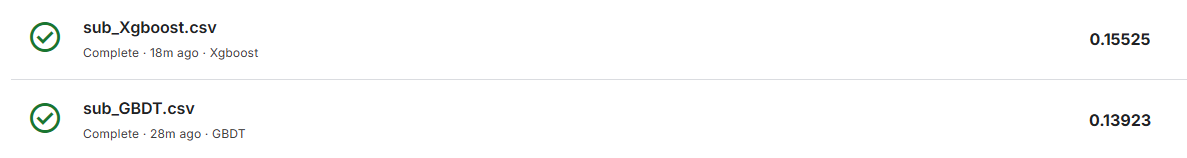